In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle
from tools import *

%matplotlib inline
sns.set_style('ticks')
sns.set_context('poster')
sns.set_style('ticks')
sns.set_context('poster')

In [2]:
raw_results = list()
for filename in [
    'results/2020-03-12T14:45:05.546544-04:00.json',
    'results/2020-03-17T02:59:00.858788-04:00.json',
    'results/2020-03-17T12:13:44.218072-04:00.json']:
        with open(filename, 'r') as infile:
            raw_results += json.load(infile)
results = list_of_dicts_to_dict_of_lists(raw_results)
del raw_results
for key, value in results.items():
    results[key] = to_nested_tuples(value)
rdf = pd.DataFrame(data=results)
del results
masks = pd.read_csv('mnist_masks.csv')

In [3]:
rdf = rdf[rdf['success']]
for i in rdf.index:
    if (rdf.at[i, 'optimizer'] == 'sgd') and (float(rdf.at[i, 'momentum']) > 0):
        rdf.at[i, 'optimizer'] = 'momentum'
optimizer_nice_names = {'adam': 'Adam', 'momentum': 'Momentum', 'rms': 'RMSProp', 'sgd': 'SGD', 'nmom': 'IMomentum'}

In [4]:
summary = get_summary(rdf[rdf['init_seed'] < 50])
best = get_best(summary, 'time')
validation_rows = get_only_best(rdf[rdf['init_seed'] < 50], best)
validation_total_times = {optimizer: list() for optimizer in rdf['optimizer'].unique()}
for _, row in validation_rows.iterrows():
    validation_total_times[row['optimizer']].append(sum(row['phase_length']))

test_rows = rdf[rdf['init_seed'] >= 50]
test_total_times = {optimizer: list() for optimizer in rdf['optimizer'].unique()}
for _, row in test_rows.iterrows():
    test_total_times[row['optimizer']].append(sum(row['phase_length']))

text = ''
text += '|-----------|------------------|------------------|\n'
text += '| Optimizer | Validation Steps | Test Steps       |\n'
text += '|-----------|------------------|------------------|\n'
for optimizer in sorted(list(validation_total_times.keys())):
    text += '| {0:>9} | {1:>6.2f}±{2:<5.2f}     | {3:>6.2f}±{4:<5.2f}     |\n'.format(
        optimizer,
        np.mean(validation_total_times[optimizer]),
        np.std(validation_total_times[optimizer]) / np.sqrt(len(validation_total_times[optimizer])),
        np.mean(test_total_times[optimizer]),
        np.std(test_total_times[optimizer]) / np.sqrt(len(test_total_times[optimizer])))
text += '|-----------|------------------|------------------|'
with open('total_steps.txt', 'w') as outfile:
    print(text, file=outfile)
print(text)

|-----------|------------------|------------------|
| Optimizer | Validation Steps | Test Steps       |
|-----------|------------------|------------------|
|      adam | 611.80±11.73     | 600.08±5.53      |
|  momentum | 552.60±9.04      | 555.26±5.56      |
|       rms | 283.90±8.26      | 277.54±3.82      |
|       sgd | 368.30±13.69     | 360.86±4.93      |
|-----------|------------------|------------------|


In [5]:
rdf = rdf[rdf['init_seed'] >= 50]

In [6]:
max_phase_lengths = list()
for _, row in rdf.iterrows():
    for i, l in enumerate(row['phase_length']):
        if len(max_phase_lengths) == i:
            max_phase_lengths.append(0)
        max_phase_lengths[i] = max(max_phase_lengths[i], l)
data = dict()
for k,v in best.items():
    data[k] = dict()
    data[k]['count'] = [np.zeros(i, dtype=int) for i in max_phase_lengths]
    for k2 in ['count',
               'd1_avg',
               'd1_sec',
               'd1_min',
               'd1_max',
               'd2_avg',
               'd2_sec',
               'd2_min',
               'd2_max',
               'online_avg',
               'online_sec',
               'online_min',
               'online_max',
               'pi_avg',
               'pi_sec',
               'pi_min',
               'pi_max',
               'ao_avg',
               'ao_sec',
               'ao_min',
               'ao_max']:
        data[k][k2] = [np.zeros(i, dtype=float) for i in max_phase_lengths]
    data[k]['phase_lengths'] = [list() for i in max_phase_lengths]
    for i in range(len(max_phase_lengths)):
        data[k]['d1_min'][i] += 1
        data[k]['d2_min'][i] += 1
    kdf = rdf[rdf['optimizer'] == k]
    for _, row in kdf.iterrows():
        j = 0
        for i, l in enumerate(row['phase_length']):
            data[k]['count'][i][:l] += 1
            data[k]['phase_lengths'][i].append(l)

            values = np.array(row['accuracies'])[j:j + l, 0]
            delta = values - data[k]['d1_avg'][i][:len(values)]
            data[k]['d1_avg'][i][:len(delta)] += delta / data[k]['count'][i][:len(values)]
            data[k]['d1_sec'][i][:len(delta)] += delta * (values - data[k]['d1_avg'][i][:len(values)])
            data[k]['d1_min'][i][:len(values)] = np.minimum(data[k]['d1_min'][i][:len(values)], values)
            data[k]['d1_max'][i][:len(values)] = np.maximum(data[k]['d1_max'][i][:len(values)], values)

            values = np.array(row['accuracies'])[j:j + l, 1]
            delta = values - data[k]['d2_avg'][i][:len(values)]
            data[k]['d2_avg'][i][:len(delta)] += delta / data[k]['count'][i][:len(values)]
            data[k]['d2_sec'][i][:len(delta)] += delta * (values - data[k]['d2_avg'][i][:len(values)])
            data[k]['d2_min'][i][:len(values)] = np.minimum(data[k]['d2_min'][i][:len(values)], values)
            data[k]['d2_max'][i][:len(values)] = np.maximum(data[k]['d2_max'][i][:len(values)], values)

            values = np.cumsum(np.array(row['correct'])[j:j + l]) / (np.arange(l) + 1)
            delta = values - data[k]['online_avg'][i][:len(values)]
            data[k]['online_avg'][i][:len(delta)] += delta / data[k]['count'][i][:len(values)]
            data[k]['online_sec'][i][:len(delta)] += delta * (values - data[k]['online_avg'][i][:len(values)])
            data[k]['online_min'][i][:len(values)] = np.minimum(data[k]['online_min'][i][:len(values)], values)
            data[k]['online_max'][i][:len(values)] = np.maximum(data[k]['online_max'][i][:len(values)], values)
            
            values = np.array(row['pairwise_interference'])[j:j + l]
            delta = values - data[k]['pi_avg'][i][:len(values)]
            data[k]['pi_avg'][i][:len(delta)] += delta / data[k]['count'][i][:len(values)]
            data[k]['pi_sec'][i][:len(delta)] += delta * (values - data[k]['pi_avg'][i][:len(values)])
            data[k]['pi_min'][i][:len(values)] = np.minimum(data[k]['pi_min'][i][:len(values)], values)
            data[k]['pi_max'][i][:len(values)] = np.maximum(data[k]['pi_max'][i][:len(values)], values)
            
            values = np.array(row['activation_overlap'])[j:j + l]
            delta = values - data[k]['ao_avg'][i][:len(values)]
            data[k]['ao_avg'][i][:len(delta)] += delta / data[k]['count'][i][:len(values)]
            data[k]['ao_sec'][i][:len(delta)] += delta * (values - data[k]['ao_avg'][i][:len(values)])
            data[k]['ao_min'][i][:len(values)] = np.minimum(data[k]['ao_min'][i][:len(values)], values)
            data[k]['ao_max'][i][:len(values)] = np.maximum(data[k]['ao_max'][i][:len(values)], values)
            
            j += l
    data[k]['d1_sem'] = list()
    data[k]['d2_sem'] = list()
    data[k]['online_sem'] = list()
    data[k]['pi_sem'] = list()
    data[k]['ao_sem'] = list()
    for i in range(len(max_phase_lengths)):
        data[k]['d1_sem'].append(np.nan_to_num(np.sqrt(data[k]['d1_sec'][i]) / data[k]['count'][i]))
        data[k]['d2_sem'].append(np.nan_to_num(np.sqrt(data[k]['d2_sec'][i]) / data[k]['count'][i]))
        data[k]['online_sem'].append(np.nan_to_num(np.sqrt(data[k]['online_sec'][i]) / data[k]['count'][i]))
        data[k]['pi_sem'].append(np.nan_to_num(np.sqrt(data[k]['pi_sec'][i]) / data[k]['count'][i]))
        data[k]['ao_sem'].append(np.nan_to_num(np.sqrt(data[k]['ao_sec'][i]) / data[k]['count'][i]))
    del data[k]['d1_sec']
    del data[k]['d2_sec']
    del data[k]['online_sec']
    del data[k]['pi_sec']
    del data[k]['ao_sec']

/Users/dylanashley/.miniconda3/envs/tensorflow-1.13.1/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/tensorflow-1.13.1/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/tensorflow-1.13.1/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/tensorflow-1.13.1/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/tensorflow-1.13.1/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide


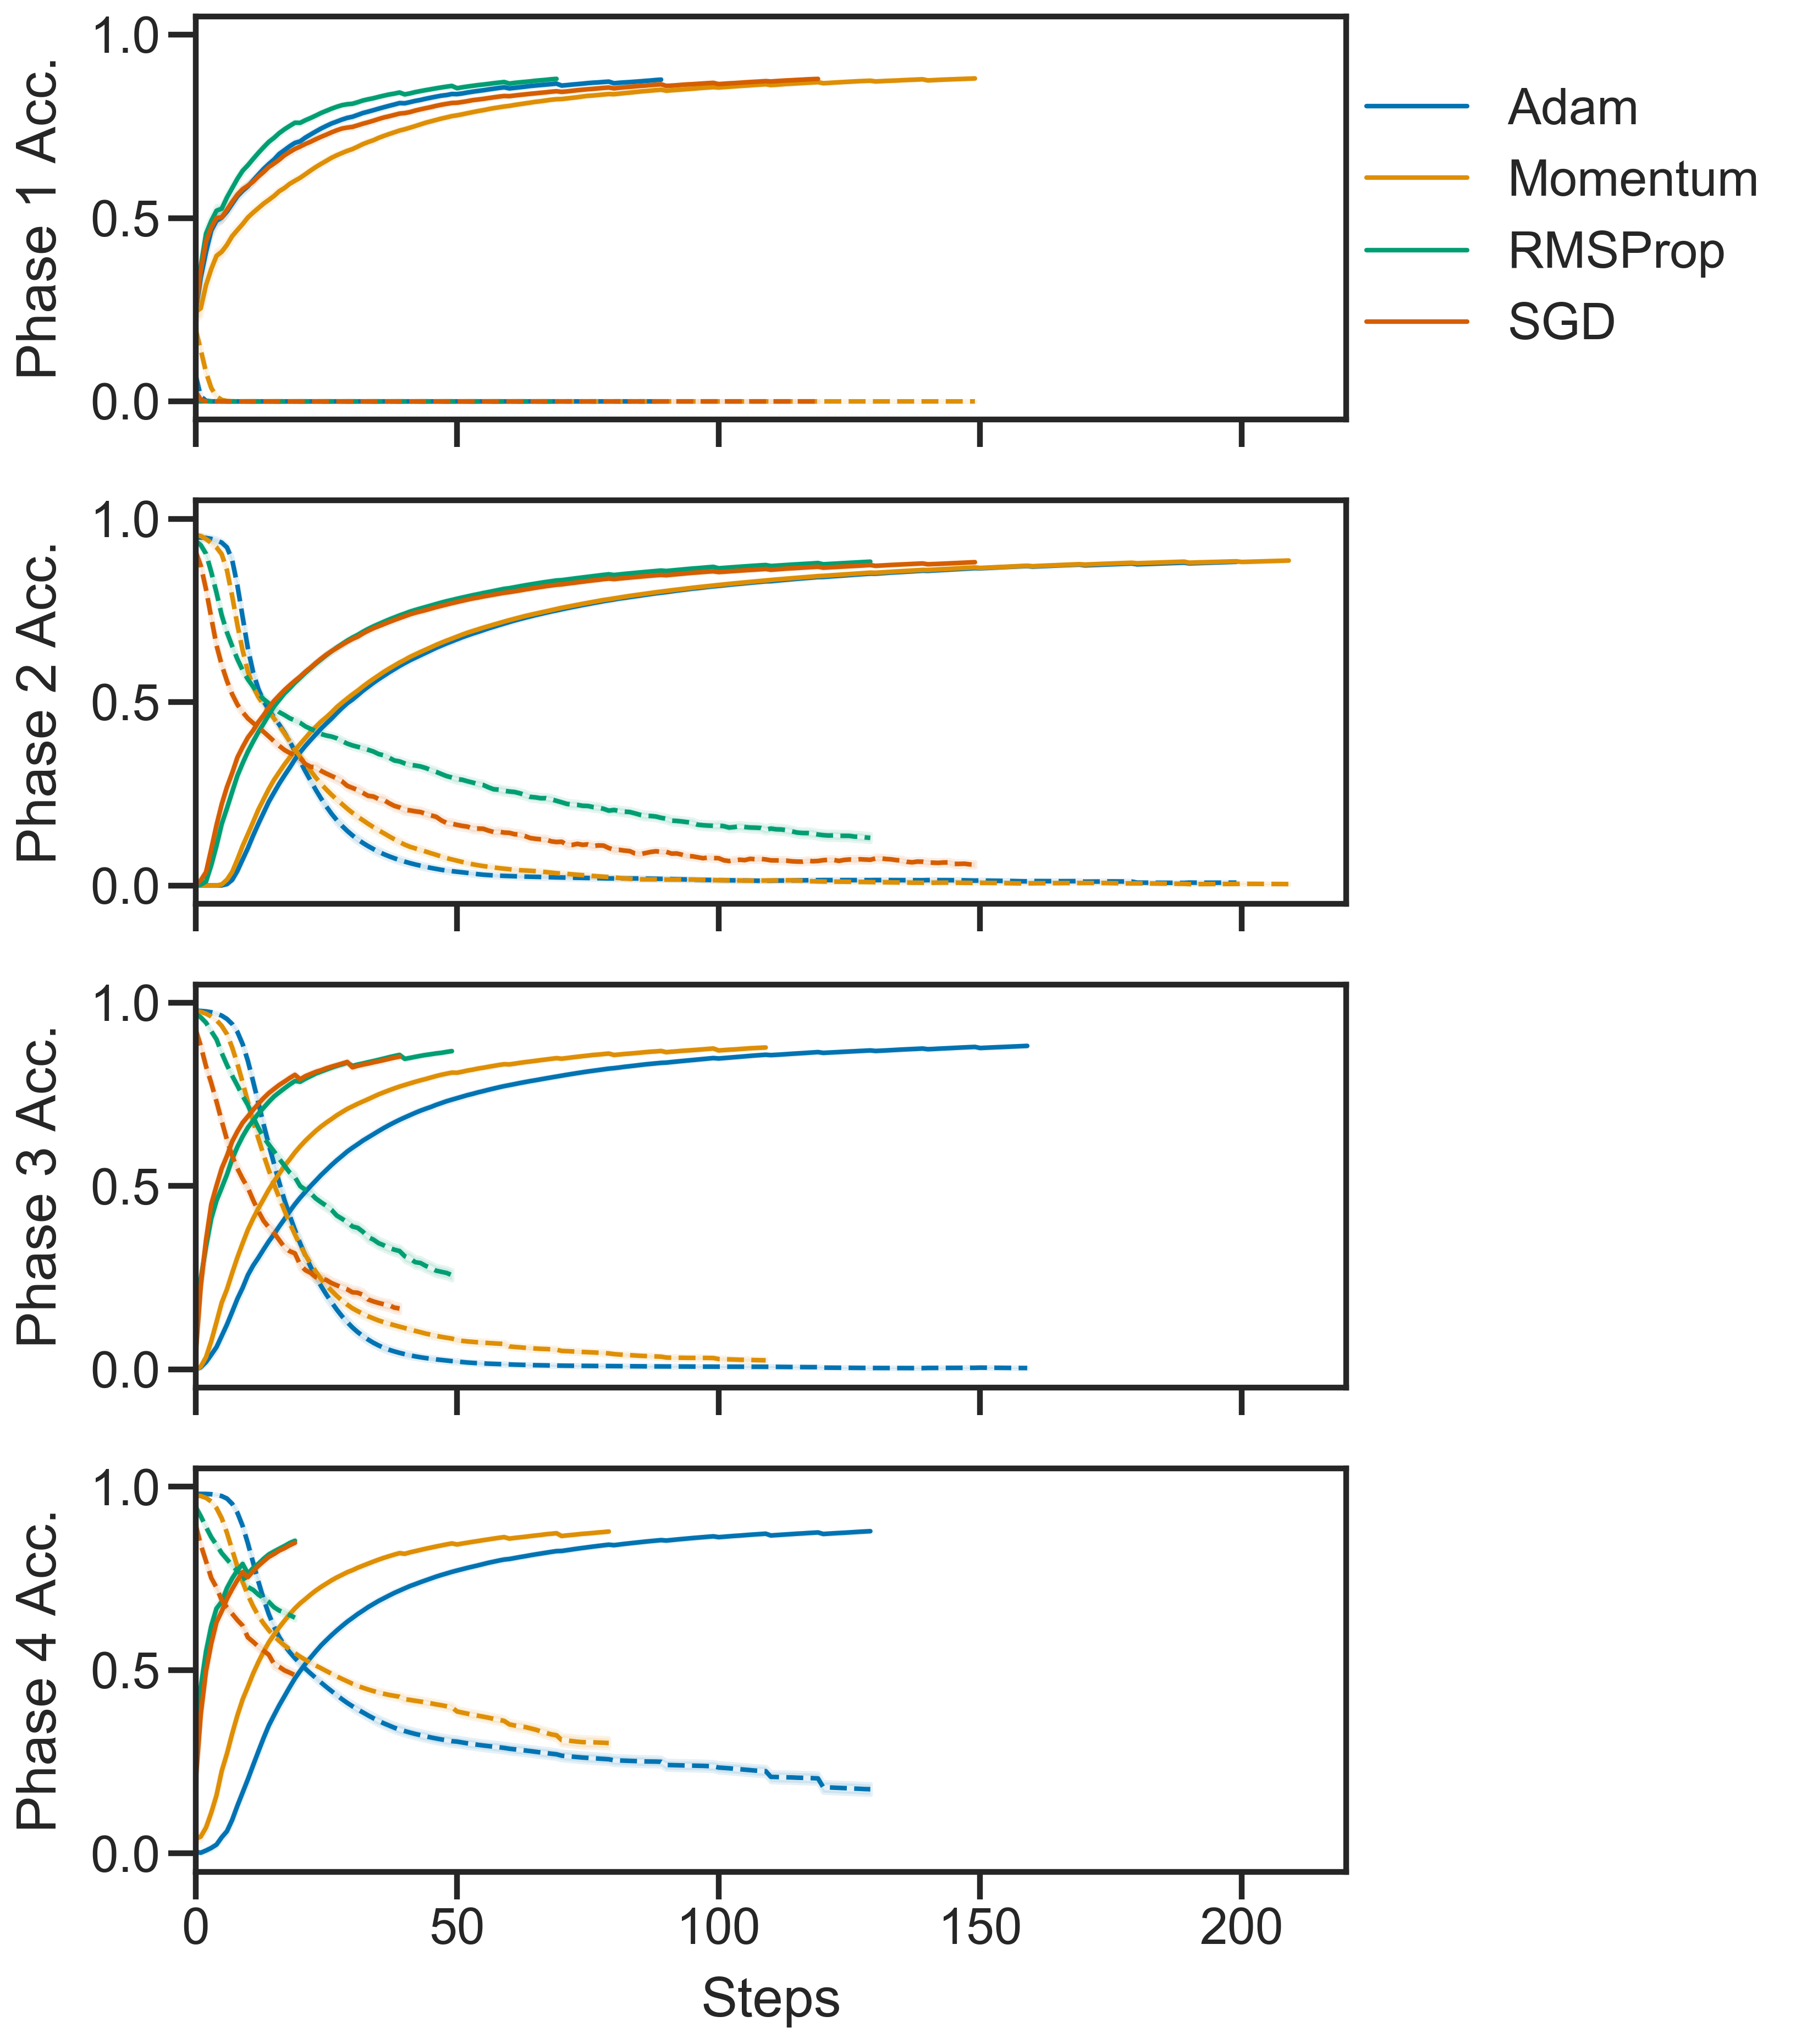

In [7]:
threshold = 125
fig, axarr = plt.subplots(4, 1, figsize=(9, 6), dpi=300, sharex=True)
colors = sns.color_palette('colorblind', len(data.keys()))
xmax = 0
for j in range(len(axarr)):
    ax = axarr[j]
    for i, (k, v) in enumerate(sorted(data.items(), key=lambda x: x[0])):
        steps_over_threshold = sum(v['count'][j] >= threshold)
        true_threshold = int(v['count'][j][steps_over_threshold] + 0.5)
        y = v['d{}_avg'.format((j + 1) % 2 + 1)][j][:steps_over_threshold]
        yerr = v['d{}_sem'.format((j + 1) % 2 + 1)][j][:steps_over_threshold]
        x = np.arange(len(y))
        xmax = max(xmax, len(x))
        ax.fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
        ax.plot(x, y, color=colors[i], linestyle='--', linewidth=2)
        y = v['online_avg'][j][:steps_over_threshold]
        yerr = v['online_sem'][j][:steps_over_threshold]
        x = np.arange(len(y))
        ax.fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
        ax.plot(x, y, label=optimizer_nice_names[k], color=colors[i], linestyle='-', linewidth=2)
for j in range(len(axarr)):
    ax = axarr[j]
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_xlim((0, xmax + 10))
    ax.set_ylabel('Phase {} Acc.'.format(j + 1), labelpad=10)
ax.set_xlabel('Steps', labelpad=10)
plt.legend(frameon=False, loc=(1, 3.725))
plt.subplots_adjust(top=2)
fig.savefig('all_phases_comparison.png', bbox_inches='tight')

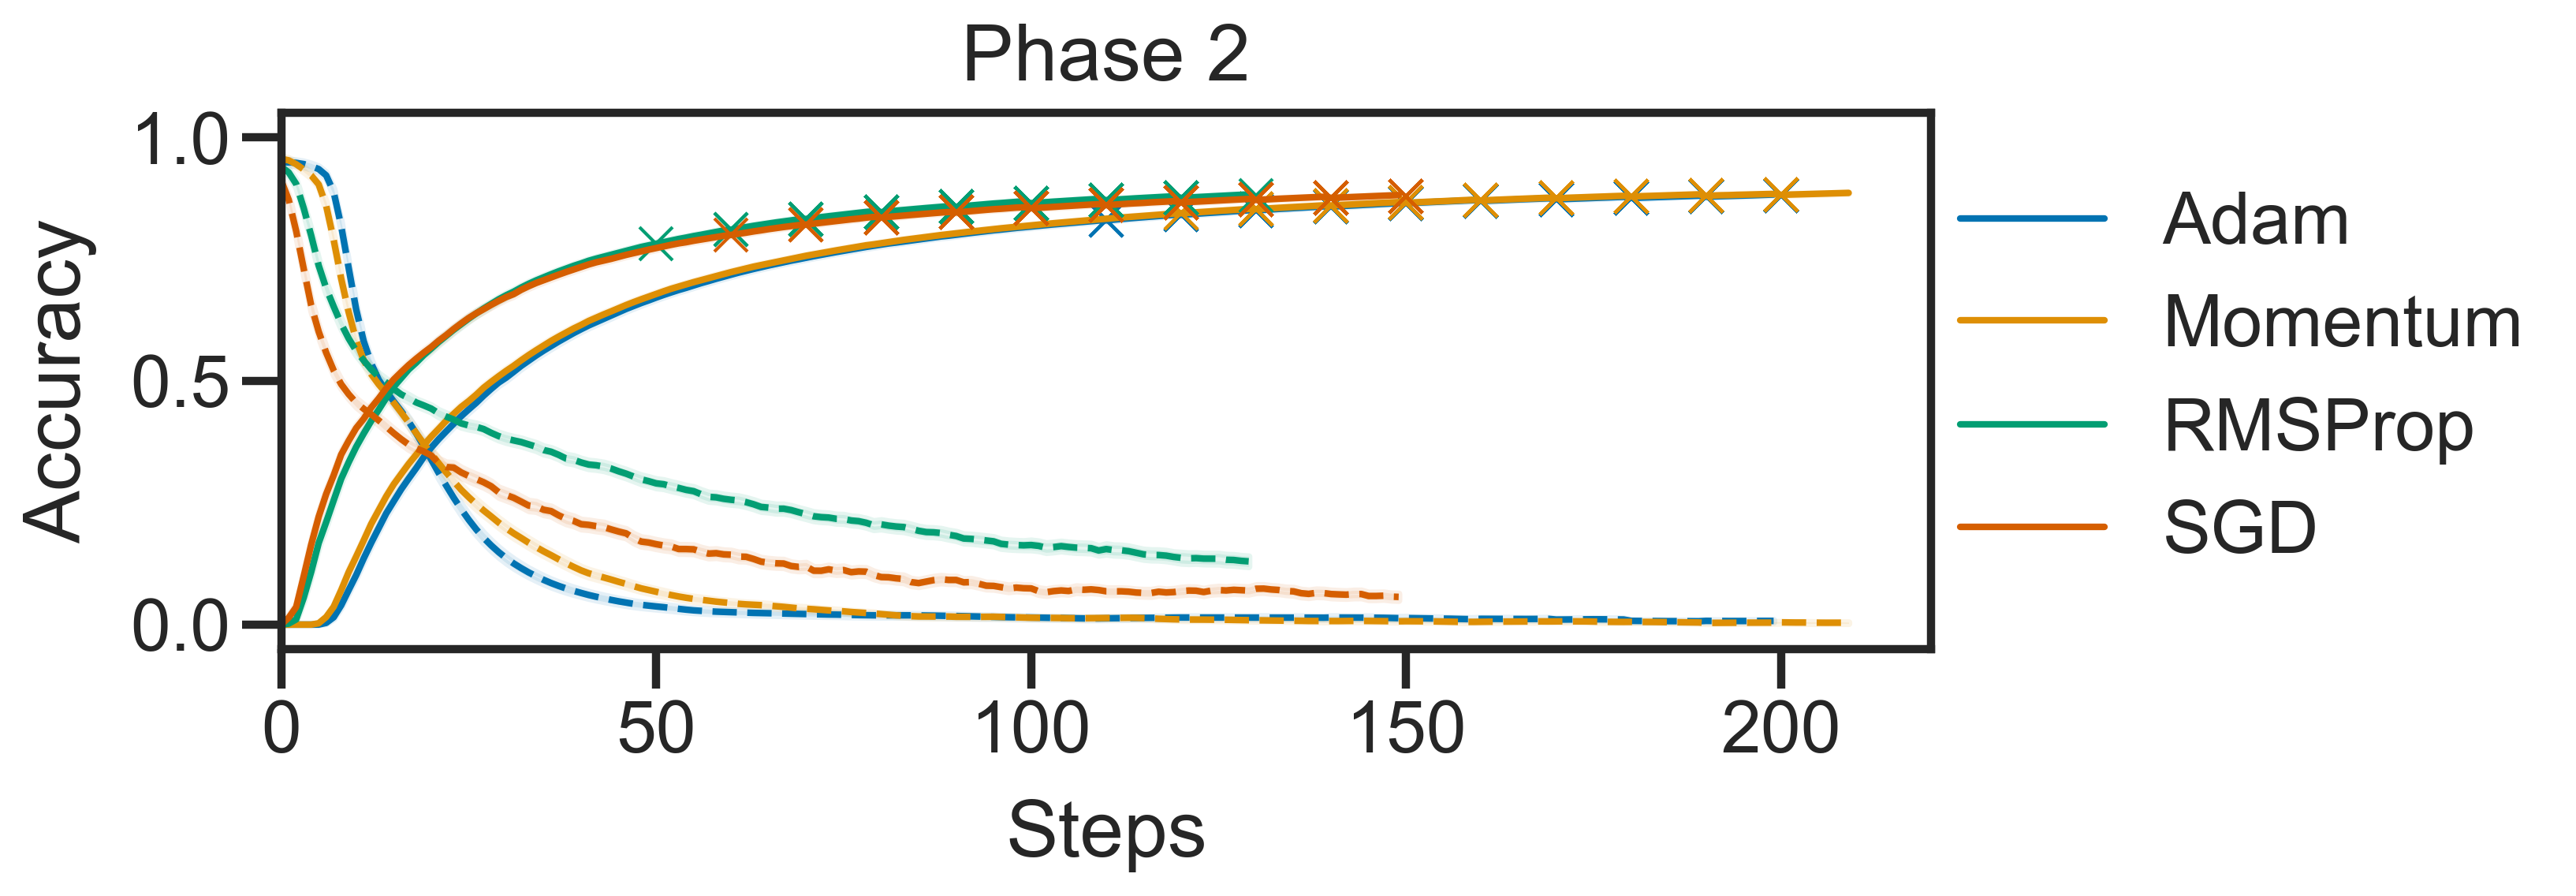

In [8]:
threshold = 125
fig, ax = plt.subplots(1, 1, figsize=(9, 3), dpi=300)
colors = sns.color_palette('colorblind', len(data.keys()))
xmax = 0
for i, (k, v) in enumerate(sorted(data.items(), key=lambda x: x[0])):
    j = 1
    steps_over_threshold = sum(v['count'][j] >= threshold)
    true_threshold = int(v['count'][j][steps_over_threshold] + 0.5)
    y = v['d1_avg'][j][:steps_over_threshold]
    yerr = v['d1_sem'][j][:steps_over_threshold]
    x = np.arange(len(y))
    xmax = max(xmax, len(x))
    ax.fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
    ax.plot(x, y, color=colors[i], linestyle='--', linewidth=2)
    y = v['online_avg'][j][:steps_over_threshold]
    yerr = v['online_sem'][j][:steps_over_threshold]
    x = np.arange(len(y))
    ax.fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
    ax.plot(x, y, label=optimizer_nice_names[k], color=colors[i], linestyle='-', linewidth=2)
    x = np.array(sorted(v['phase_lengths'][j]))[:true_threshold + 1]
    y = np.zeros(x.shape)
    for a, b in enumerate(x):
        y[a] = v['online_avg'][j][b]
    ax.plot(x, y, linewidth=0, marker='x', markersize=10, color=colors[i])
ax.set_ylim(-0.05, 1.05)
ax.set_yticks([0.0, 0.5, 1.0])
ax.set_xlim((0, xmax + 10))
ax.set_xlabel('Steps', labelpad=10)
ax.set_ylabel('Accuracy', labelpad=10)
ax.set_title('Phase 2', pad=10)
plt.legend(frameon=False, loc=(1, 0.1))
fig.savefig('phase_2_comparison.png', bbox_inches='tight')

In [9]:
text = ''
phase_lengths = [{optimizer: list() for optimizer in rdf['optimizer'].unique()} for _ in range(4)]
for _, row in rdf.iterrows():
    for i in range(4):
        phase_lengths[i][row['optimizer']].append(row['phase_length'][i])
text += '|-----------|------------------|------------------|------------------|------------------|\n'
text += '| Optimizer | Steps in Phase 1 | Steps in Phase 2 | Steps in Phase 3 | Steps in Phase 4 |\n'
text += '|-----------|------------------|------------------|------------------|------------------|\n'
for optimizer in sorted(list(phase_lengths[0].keys())):
    text += '| {0:>9} | {1:>6.2f}±{2:<5.2f}     | {3:>6.2f}±{4:<5.2f}     | {5:>6.2f}±{6:<5.2f}     | {7:>6.2f}±{8:<5.2f}     |\n'.format(
        optimizer,
        np.mean(phase_lengths[0][optimizer]), np.std(phase_lengths[0][optimizer]) / np.sqrt(len(phase_lengths[0][optimizer])),
        np.mean(phase_lengths[1][optimizer]), np.std(phase_lengths[1][optimizer]) / np.sqrt(len(phase_lengths[1][optimizer])),
        np.mean(phase_lengths[2][optimizer]), np.std(phase_lengths[2][optimizer]) / np.sqrt(len(phase_lengths[2][optimizer])),
        np.mean(phase_lengths[3][optimizer]), np.std(phase_lengths[3][optimizer]) / np.sqrt(len(phase_lengths[3][optimizer])))
text += '|-----------|------------------|------------------|------------------|------------------|'
with open('phase_steps.txt', 'w') as outfile:
    print(text, file=outfile)
print(text)

|-----------|------------------|------------------|------------------|------------------|
| Optimizer | Steps in Phase 1 | Steps in Phase 2 | Steps in Phase 3 | Steps in Phase 4 |
|-----------|------------------|------------------|------------------|------------------|
|      adam |  89.52±2.65      | 209.00±3.08      | 166.96±2.80      | 134.60±2.56      |
|  momentum | 147.10±3.65      | 210.84±2.88      | 114.96±2.54      |  82.36±1.82      |
|       rms |  66.96±2.04      | 131.96±2.28      |  54.12±1.68      |  24.50±1.00      |
|       sgd | 120.64±3.44      | 156.56±2.99      |  54.24±2.37      |  29.42±1.31      |
|-----------|------------------|------------------|------------------|------------------|


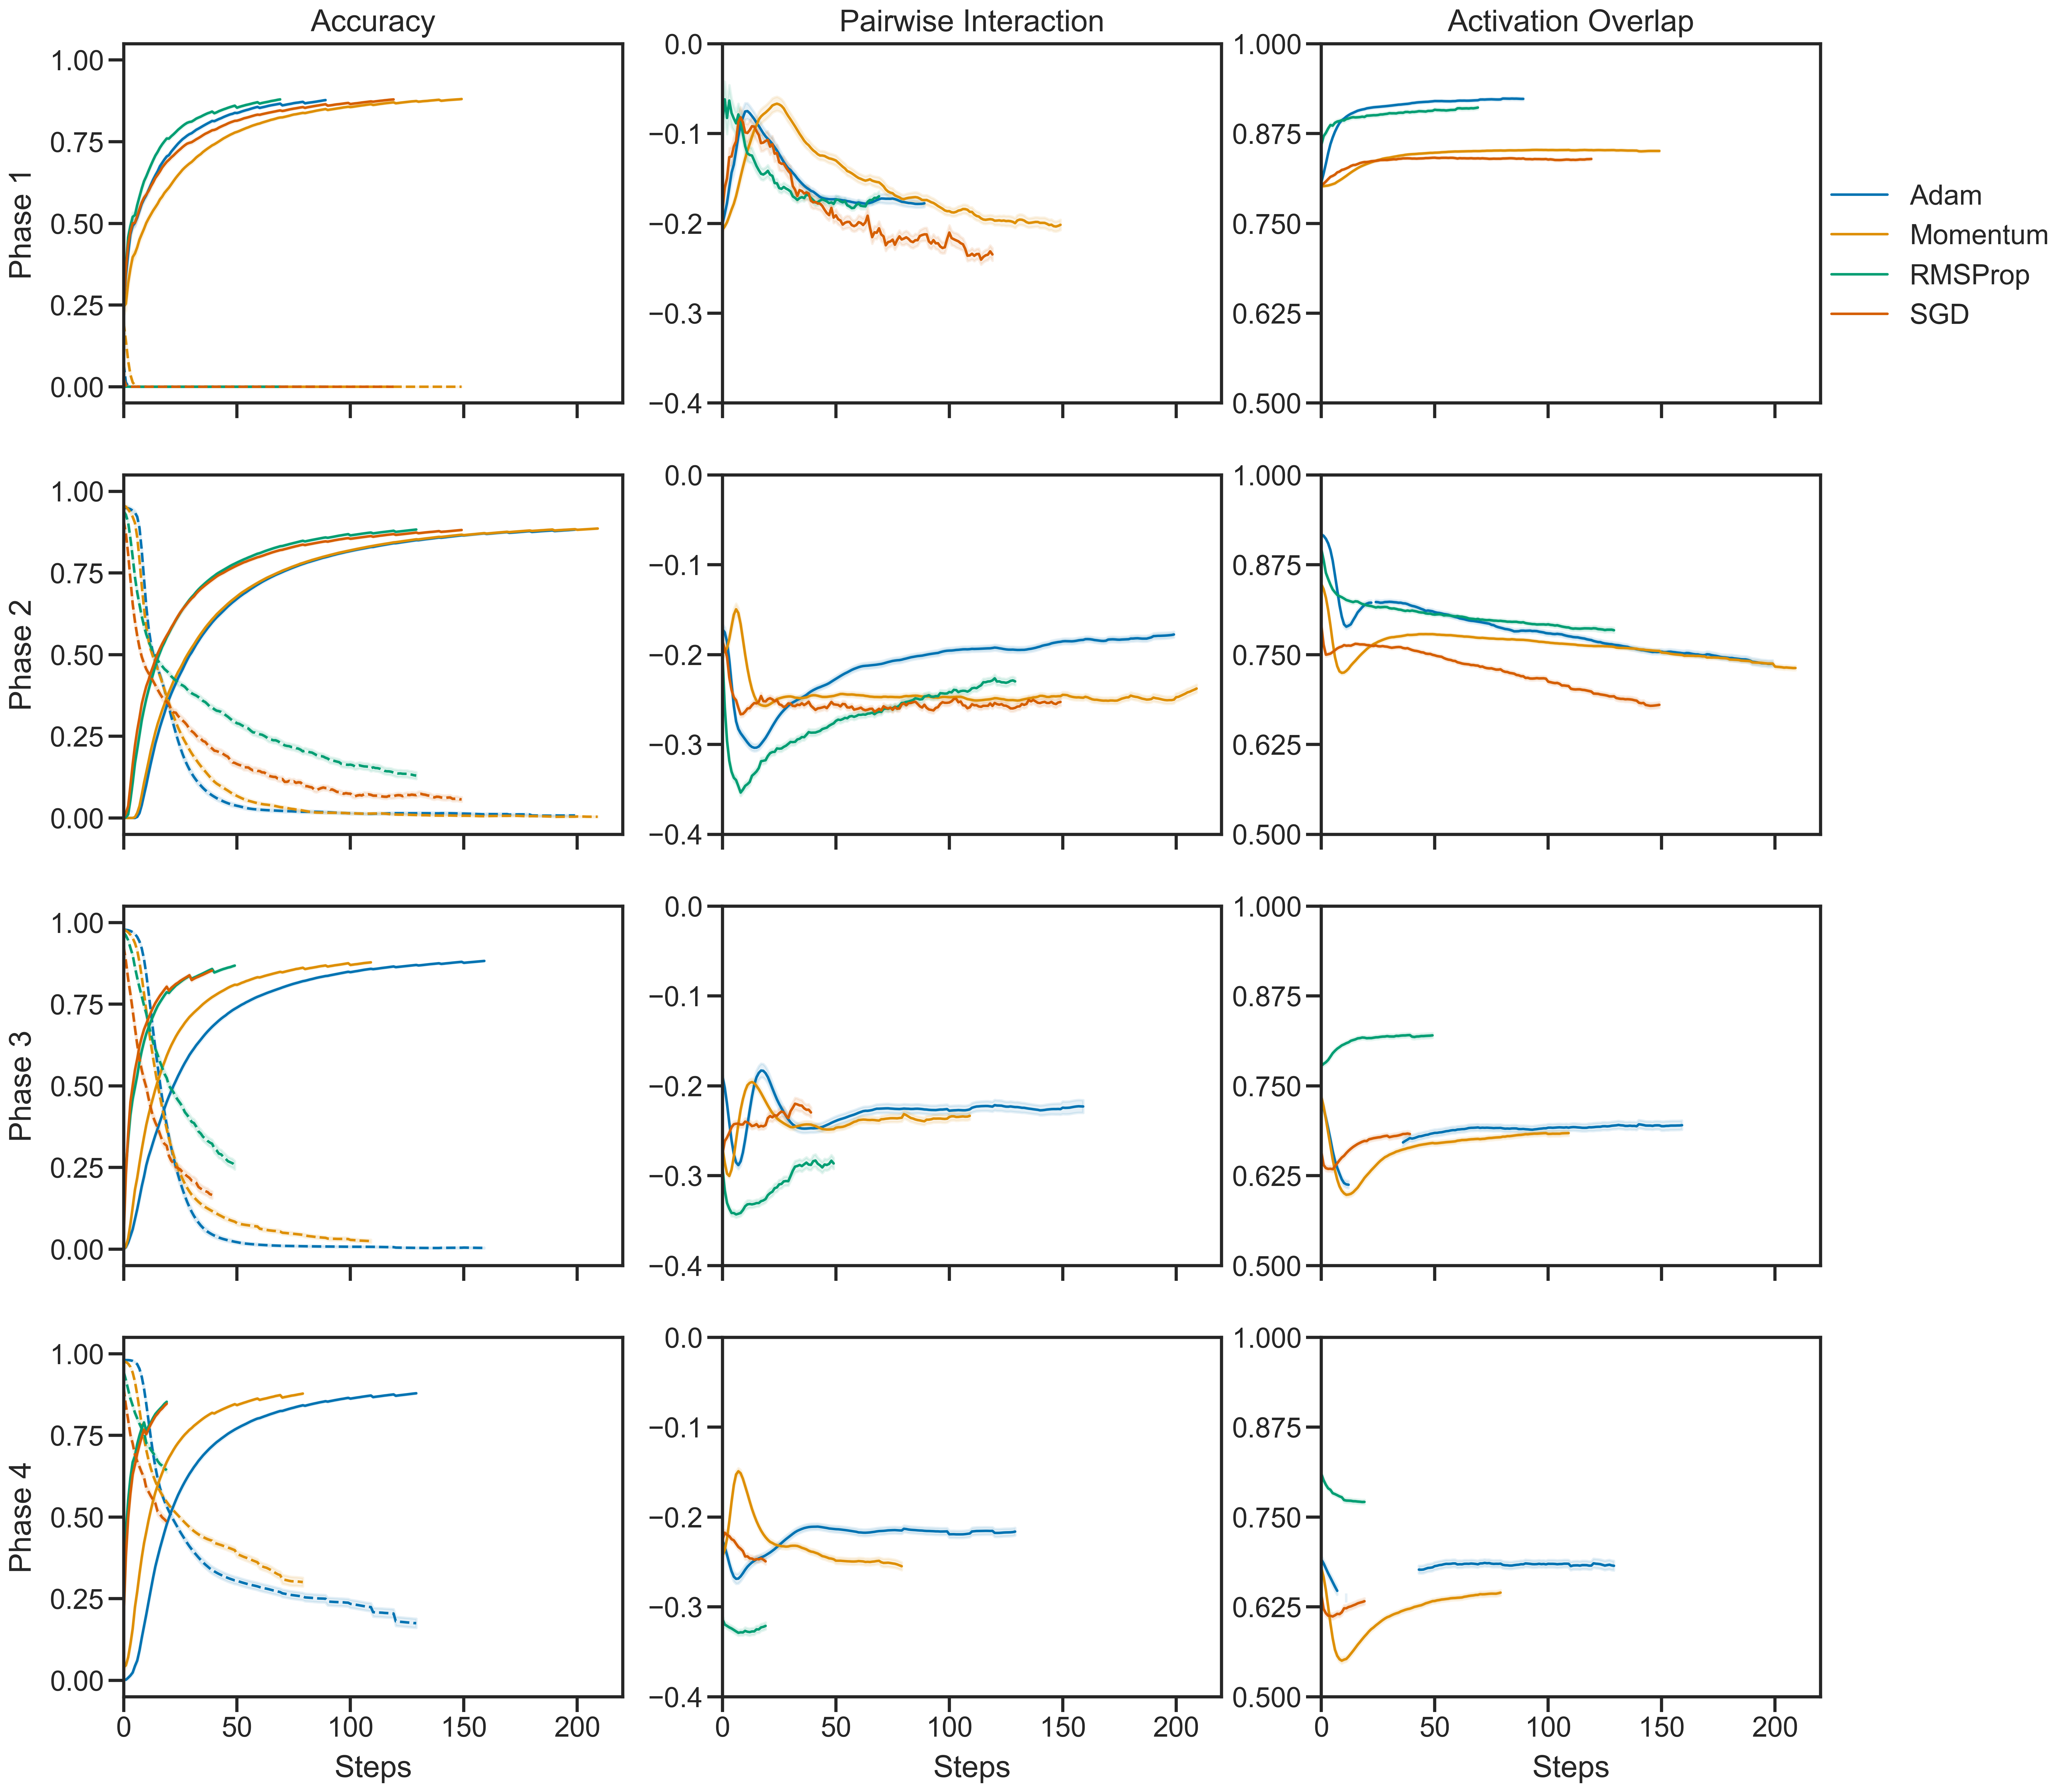

In [10]:
threshold = 125
fig, axmat = plt.subplots(4, 3, figsize=(24, 24), dpi=300, sharex=True)
colors = sns.color_palette('colorblind', len(data.keys()))
xmax = 0
for j in range(4):
    for i, (k, v) in enumerate(sorted(data.items(), key=lambda x: x[0])):
        steps_over_threshold = sum(v['count'][j] >= threshold)
        true_threshold = int(v['count'][j][steps_over_threshold] + 0.5)

        y = v['d{}_avg'.format((j + 1) % 2 + 1)][j][:steps_over_threshold]
        yerr = v['d{}_sem'.format((j + 1) % 2 + 1)][j][:steps_over_threshold]
        x = np.arange(len(y))
        xmax = max(xmax, len(x))

        axmat[j, 0].fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
        axmat[j, 0].plot(x, y, color=colors[i], linestyle='--', linewidth=2)
        y = v['online_avg'][j][:steps_over_threshold]
        yerr = v['online_sem'][j][:steps_over_threshold]
        axmat[j, 0].fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
        axmat[j, 0].plot(x, y, label=optimizer_nice_names[k], color=colors[i], linestyle='-', linewidth=2)
        
        y = v['pi_avg'][j][:steps_over_threshold]
        yerr = v['pi_sem'][j][:steps_over_threshold]
        x = np.arange(len(y))
        axmat[j, 1].fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
        axmat[j, 1].plot(x, y, label=optimizer_nice_names[k], color=colors[i], linestyle='-', linewidth=2)
        
        y = v['ao_avg'][j][:steps_over_threshold]
        yerr = v['ao_sem'][j][:steps_over_threshold]
        x = np.arange(len(y))
        axmat[j, 2].fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
        axmat[j, 2].plot(x, y, label=optimizer_nice_names[k], color=colors[i], linestyle='-', linewidth=2)
for i in range(4):
    for j in range(3):
        axmat[i, j].set_xlim((0, xmax + 10))
    axmat[i, 0].set_ylim(-0.05, 1.05)
    axmat[i, 0].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    axmat[i, 1].set_ylim(-0.4, 0.0)
    axmat[i, 1].set_yticks([-0.4, -0.3, -0.2, -0.1, 0.0])
    axmat[i, 2].set_ylim(0.5, 1.0)
    axmat[i, 2].set_yticks([0.5, 0.625, 0.75, 0.875, 1.0])
for i in range(4):
    axmat[i, 0].set_ylabel('Phase {}'.format(i + 1), labelpad=10)
for i in range(3):
    axmat[3, i].set_xlabel('Steps', labelpad=10)
axmat[0, 0].set_title('Accuracy', pad=10)
axmat[0, 1].set_title('Pairwise Interaction', pad=10)
axmat[0, 2].set_title('Activation Overlap', pad=10)
plt.legend(frameon=False, loc=(1, 3.775))
fig.savefig('all_interference_metrics.png', bbox_inches='tight')

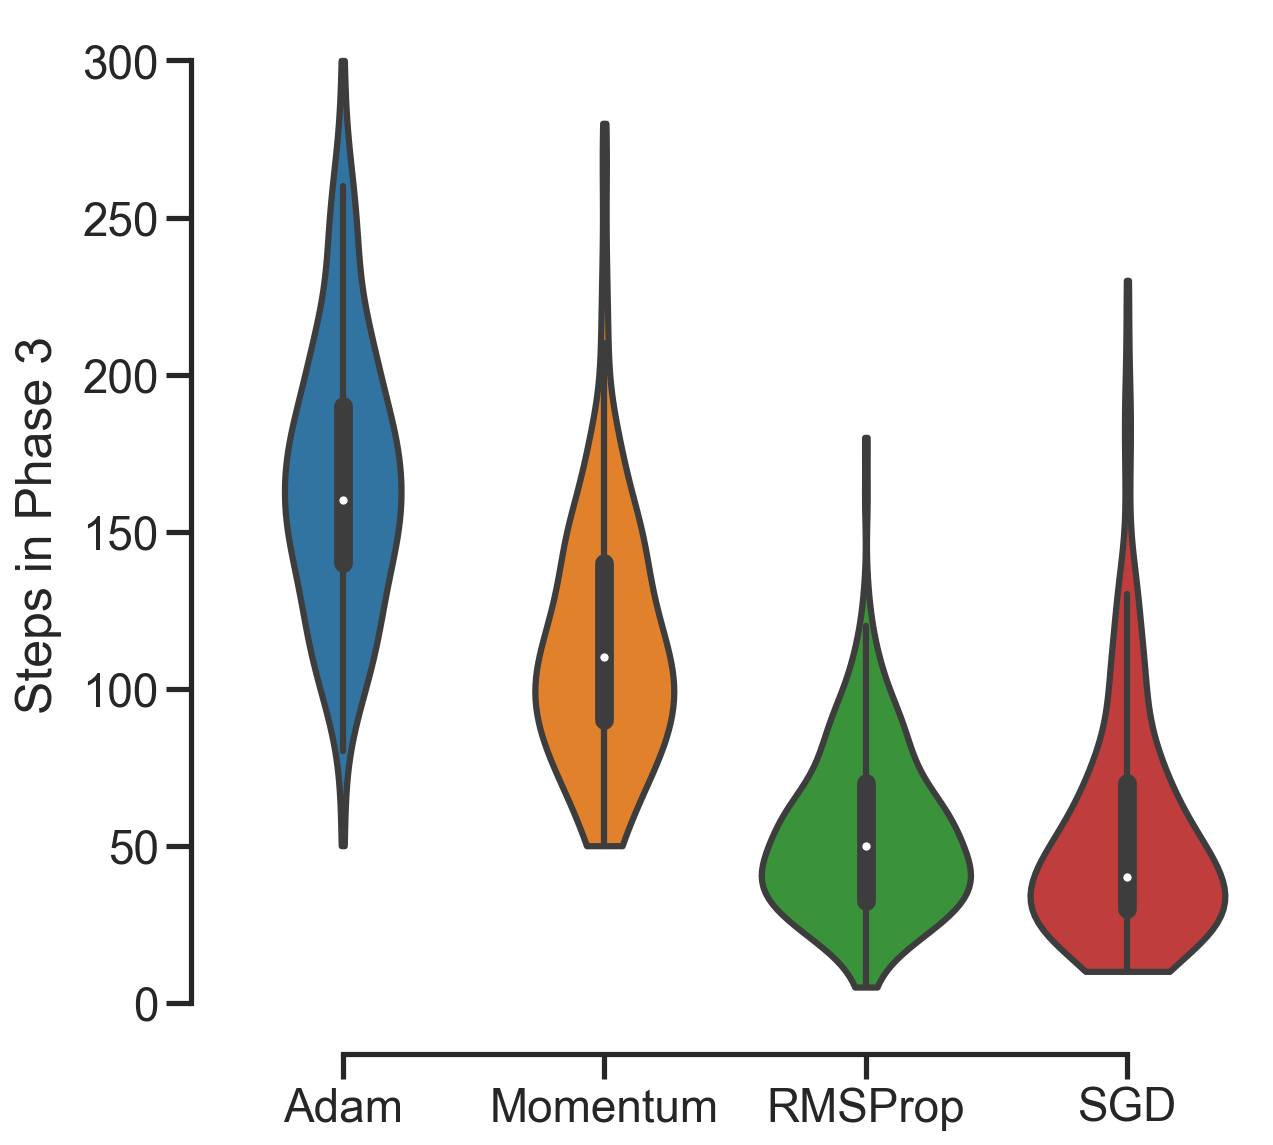

In [11]:
boxplot_data = {'optimizer': [], 'third_phase_lengths': []}
for optimizer in sorted(list(phase_lengths[2].keys())):
    for phase_length in phase_lengths[2][optimizer]:
        boxplot_data['optimizer'].append(optimizer_nice_names[optimizer])
        boxplot_data['third_phase_lengths'].append(phase_length)
fig, ax = plt.subplots(1, 1, figsize=(9, 9), dpi=150)
ax.set_ylabel('Steps in Phase 3', labelpad=10)
sns.violinplot(x=boxplot_data['optimizer'], y=boxplot_data['third_phase_lengths'], cut=0, ax=ax)
sns.despine(offset=10, trim=True)
fig.savefig('phase_3_lengths.png', bbox_inches='tight')

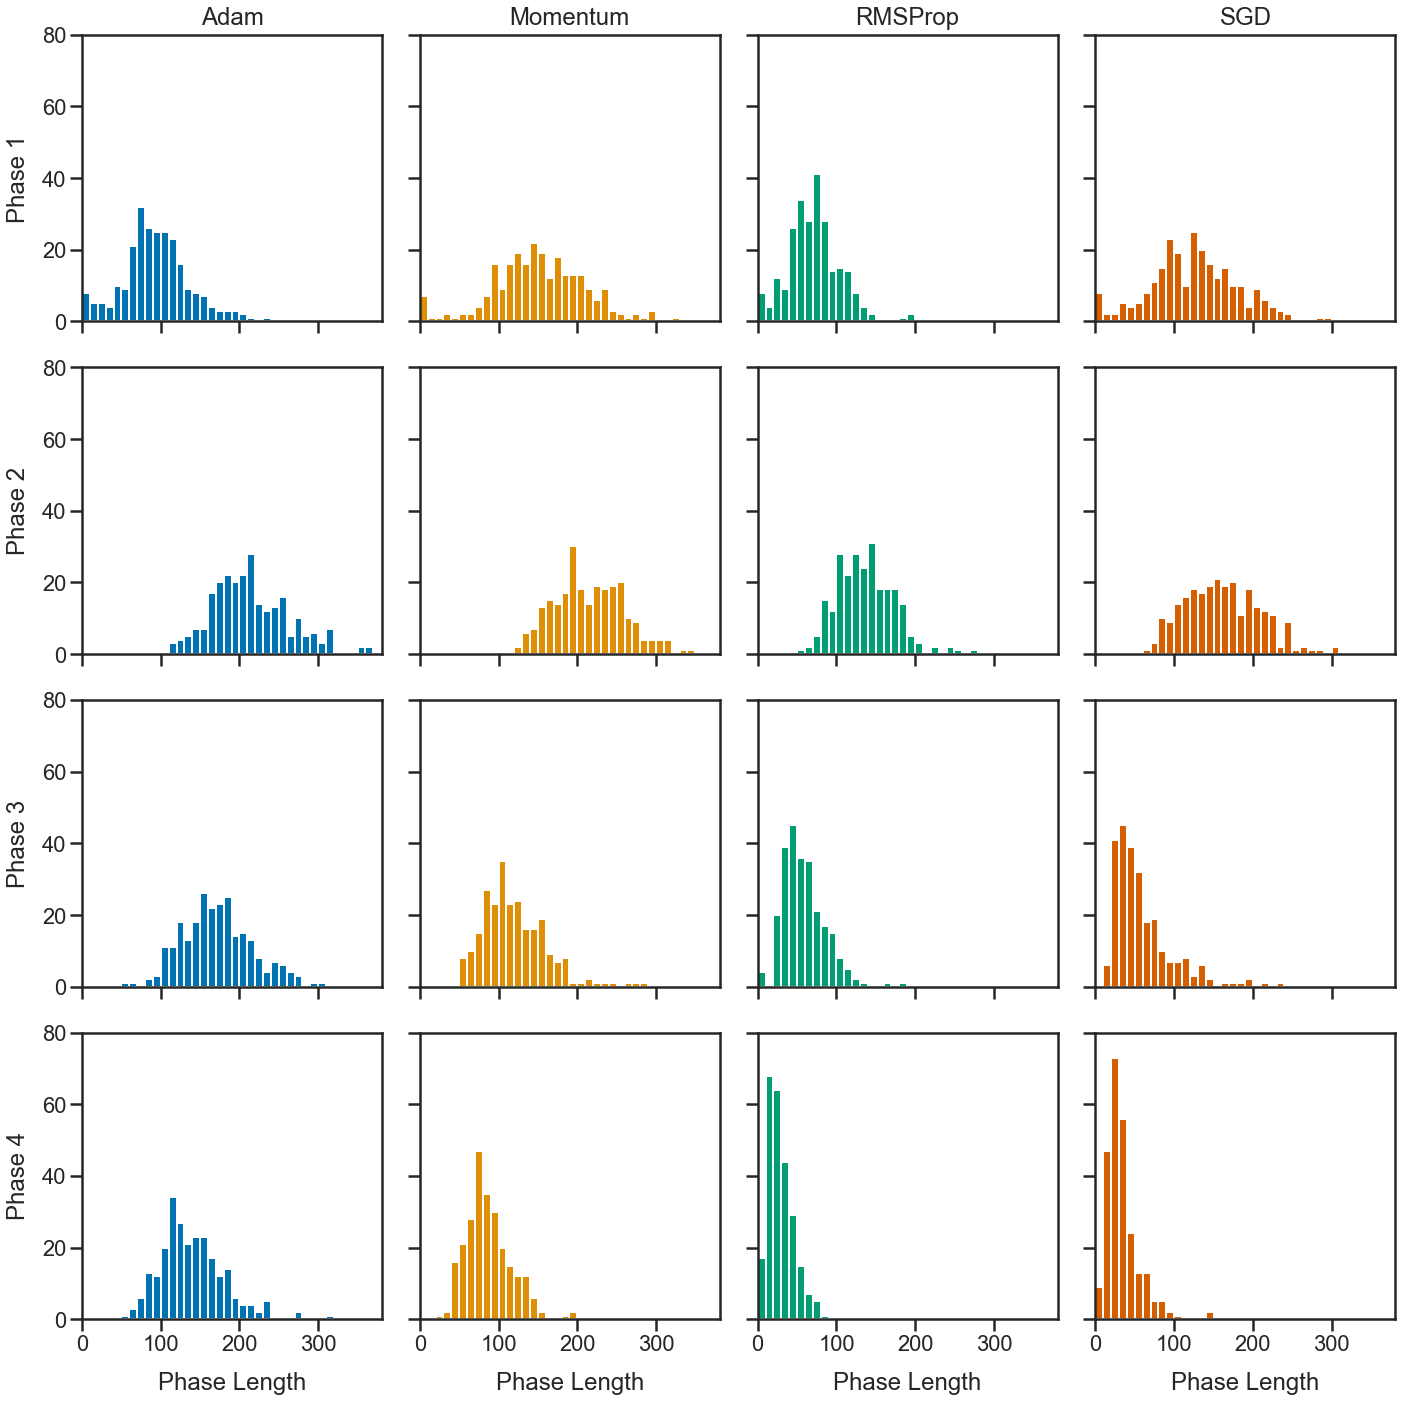

In [12]:
plt.close()
phase_lengths = {optimizer: [list() for _ in max_phase_lengths] for optimizer in rdf['optimizer'].unique()}
for _, row in rdf.iterrows():
    optimizer = row['optimizer']
    for i, phase_length in enumerate(row['phase_length']):
        phase_lengths[optimizer][i].append(phase_length)
sns.set_style('ticks')
sns.set_context('poster')
colors = sns.color_palette('colorblind', len(phase_lengths.keys()))
fig, axmat = plt.subplots(len(phase_lengths.keys()),
                          len(max_phase_lengths),
                          figsize=(5 * len(max_phase_lengths), 5 * len(phase_lengths.keys())),
                          sharex=True,
                          sharey=True)
for j, optimizer in enumerate(sorted(list(phase_lengths.keys()))):
    for i in range(len(max_phase_lengths)):
        axmat[i, j].set_xlim(0, max(max_phase_lengths) + 1)
        axmat[i, j].set_ylim(0, 80)
        axmat[i, j].hist(phase_lengths[optimizer][i], bins=range(0, max(max_phase_lengths), 10), color=colors[j])
        if i == 0:
            axmat[i, j].set_title(optimizer_nice_names[optimizer], pad=10)
        if i == len(phase_lengths.keys()) - 1:
            axmat[i, j].set_xlabel('Phase Length', labelpad=17)
            axmat[i, j].set_xticks([0, 100, 200, 300])
        if j == 0:
            axmat[i, j].set_ylabel('Phase {}'.format(i + 1), labelpad=12)
            axmat[i, j].set_yticks([0, 20, 40, 60, 80])
plt.tight_layout()
fig.savefig('all_phase_lengths.png', bbox_inches='tight')